# Исследование данных о пользователях сервиса аренды самокатов GoFast и их поездках

В нашем распоряжении несколько наборов данных, содержащих информацию по некоторым пользователям мобильного приложения GoFast из нескольких городов, а также об их поездках.\
В исследовании мы изучим основные параметры, рассчитаем помесячную выручку от каждого пользователя, а также проверим ряд гипотез, которые могут помочь бизнесу вырасти:

* Тратят ли пользователи с подпиской больше времени на поездки?
* Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает оптимального с точки зрения износа самоката?
* Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

* без подписки:
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

**Описание данных**

Файл `users_go.csv`:

* `user_id` — уникальный идентификатор пользователя
* `name` — имя пользователя
* `age` — возраст
* `city` — город
* `subscription_type` —	тип подписки (free, ultra)

Файл `rides_go.csv`:

* `user_id` — уникальный идентификатор пользователя
* `distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` — дата совершения поездки

Файл `subscriptions_go.csv`:

* `subscription_type` — тип подписки
* `minute_price` — стоимость одной минуты поездки по данной подписке
* `start_ride_price` — стоимость начала поездки
* `subscription_fee` — стоимость ежемесячного платежа

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from math import factorial
from scipy.stats import binom
from math import sqrt
import warnings
import jupyter_black

## Загрузка данных и изучение общей информации

In [2]:
# сохраняем файлы в отдельные переменные
users = pd.read_csv("users_go.csv")
rides = pd.read_csv("rides_go.csv")
subscriptions = pd.read_csv("subscriptions_go.csv")

In [3]:
pd.set_option(
    "display.max_columns", None
)  # расширяем область вывода, чтобы были видны все столбцы
warnings.filterwarnings(
    "ignore"
)  # отключаем предупреждения об изменениях в библиотеках
pd.options.display.float_format = (
    "{:.3f}".format
)  # устанавливаем настройку для отображения чисел во float формате
jupyter_black.load()  # автоматическое форматирование кода

### Изучение общей информации о полученных датафреймах

Выведем на экран первые строки из каждого датасета и применим метод info():

In [4]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [6]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919,25.600,2021-01-01
1,1,2617.592,15.817,2021-01-18
2,1,754.160,6.232,2021-04-20
3,1,2694.783,18.511,2021-08-11
4,1,4028.687,26.266,2021-08-28


In [7]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [8]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


### Промежуточный вывод

* Ни в одном из датафреймов нет пропусков.
* Стоит проверить `rides` и `users` на дубликаты.
* Стоит изменить тип столбца `date` (датафрейм `rides`) на datetime64.

## Предобработка данных

### Изменение типов данных

In [10]:
# меняем столбцу date тип данных на datetime64
rides["date"] = pd.to_datetime(rides["date"], format="%Y-%m-%d")

### Добавление нового столбца

Добавим в датафрейм `rides` дополнительный столбец `month`, куда добавим данные о месяце поездки.

In [11]:
rides["month"] = rides["date"].dt.month

Уточним временной период, который охватывают данные:

In [12]:
print("Самая ранняя дата:", rides["date"].min())
print("Самая поздняя дата:", rides["date"].max())

Самая ранняя дата: 2021-01-01 00:00:00
Самая поздняя дата: 2021-12-30 00:00:00


Данные охватывают период за 2021 год.

### Поиск и обработка дубликатов

**Поиск явных дубликатов.**

Сначала проверим датафреймы `rides` и `users` на явные дубликаты.

In [13]:
rides.duplicated().sum()

0

In [14]:
users.duplicated().sum()

31

В `rides` явных дубликатов нет, а вот в `users` обнаружился 31 дубликат с полным совпадением строк.

В этом датафрейме содержатся данные об уникальных клиентах с уникальным идентификатором пользователя user_id. Так что дубли стоит удалить.

In [15]:
# удаляем строки-дубли
users = users.drop_duplicates()

**Перейдем к поиску неявных дубликатов.**

В данном случае нас интересует только датафрейм `users`, где есть столбцы типа object со строчными значениями.  В них могут быть ошибки и опечатки.

Всего таких столбца три:
* name - имя пользователя
* city - город
* subscription_type - тип подписки (free, ultra)

Также проверим столбец 'user_id' на отсутствие повторяющихся id.

In [16]:
# сортировка столбца 'user_id' по уникальным значениям, суммирование строк и вывод самого большего количества
users["user_id"].value_counts().max()

1

Все значения в столбце `user_id` встречаются только один раз.

---

Изучим столбец `'name'`:

In [17]:
# вывод на экран уникальных значений в алфавитном порядке
names_unique = np.sort(users["name"].unique())
for name in names_unique:
    print(name)

Агата
Аделина
Адель
Айдар
Александр
Александра
Алексей
Алина
Алиса
Алия
Алла
Альберт
Альбина
Алёна
Амалия
Амина
Амир
Анастасия
Анатолий
Ангелина
Андрей
Анжелика
Анна
Антон
Антонина
Ариана
Арина
Арсен
Арсений
Артемий
Артур
Артём
Богдан
Борис
Вадим
Валентина
Валерий
Валерия
Варвара
Василий
Василина
Василиса
Вера
Вероника
Виктор
Виктория
Виолетта
Виталий
Виталина
Влад
Влада
Владимир
Владислав
Владислава
Всеволод
Вячеслав
Галина
Георгий
Герман
Глеб
Гордей
Григорий
Давид
Дамир
Даниил
Данил
Данила
Даниэль
Дарина
Дарья
Демид
Денис
Диана
Дмитрий
Ева
Евгений
Евгения
Егор
Екатерина
Елена
Елизавета
Елисей
Есения
Жанна
Зарина
Захар
Злата
Иван
Игнат
Игорь
Ильдар
Илья
Инна
Ирина
Камилла
Карина
Каролина
Кира
Кирилл
Константин
Кристина
Ксения
Лариса
Лев
Леонид
Лиана
Лидия
Лилия
Любовь
Людмила
Мадина
Майя
Макар
Максим
Марат
Маргарита
Марина
Мария
Марк
Марсель
Матвей
Мелания
Милана
Милена
Мирон
Мирослав
Мирослава
Михаил
Назар
Наталия
Наталья
Наташа
Нелли
Ника
Никита
Николай
Нина
Одиссей
Оксана
Олег
Олес

Опечаток нет, все имена написаны единообразно. Есть пары схожих имен, например `София и Софья`, 
`Наталия и Наталья`, но можно отнести это к разным стилям написания, да и в контексте нашего исследования такие сходства в именах не критичны. Так что оставим их как есть.

Подобным образом изучим столбец `city`: 

In [18]:
# показать уникальные значения в столбце
cities_unique = np.sort(users["city"].unique())
for name in cities_unique:
    print(name)

Екатеринбург
Краснодар
Москва
Омск
Пятигорск
Ростов-на-Дону
Сочи
Тюмень


Тут все хорошо, данные в таблице охватывают всего 8 городов, ошибок нет.

Перейдем к проверке столбца `subscription_type`. Он может содержать только два уникальных значения 'ultra' и 'free'.

In [19]:
users["subscription_type"].unique()

array(['ultra', 'free'], dtype=object)

Все верно, ошибок в столбце нет.

### Промежуточный вывод

Мы подготовили данные к работе:
* Проверили данные на наличие пропусков, а также явных и неявных дубликатов (удалили явные и обнаружили отсутствие скрытых)
* В датасете `rides` — добавили новый столбец `month`, а также исправили тип столбца `date` на datetime64

## Исследовательский анализ данных

### Распределение пользователей по городам

In [20]:
# отсортируем уникальные значения по количеству упоминаний
users["city"].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

Визуализируем данные на графике

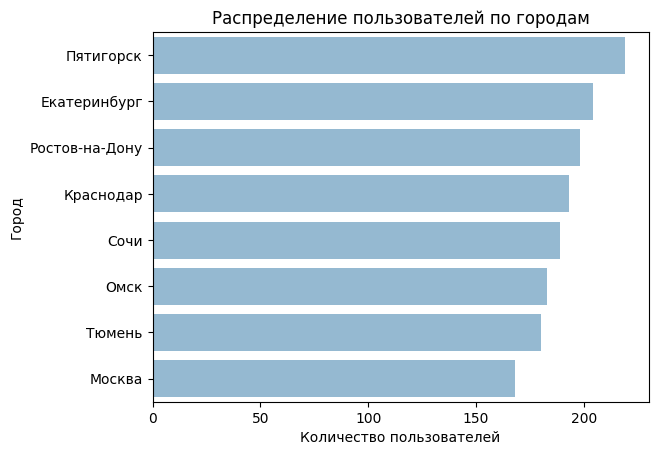

In [21]:
sns.set_palette("Blues_d")  # задаем цвета библиотеке seaborn

# готовим данные для графика
cities_frequency = users["city"].value_counts().reset_index()
cities_frequency.columns = ["Город", "Количество пользователей"]

# строим барплот
sns.barplot(data=cities_frequency, x="Количество пользователей", y="Город").set(
    title="Распределение пользователей по городам"
);

**Наблюдение:**  Интересно, что в датафрейме больше всего пользователей из небольшого по населению города Пятигорска, а меньше всего из самого населенного города Европы, Москвы.

### Соотношение пользователей с подпиской и без
Выведем на экран процент по каждому варианту.

In [22]:
users["subscription_type"].value_counts(normalize=True) * 100

subscription_type
free    54.433
ultra   45.567
Name: proportion, dtype: float64

Визуализируем на круговой диаграмме

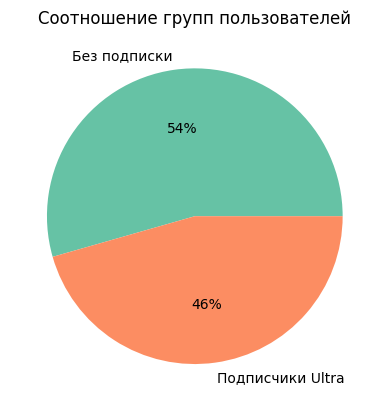

In [23]:
sns.set_palette("Set2")
plt.title("Cоотношение групп пользователей")
plt.pie(
    users["subscription_type"].value_counts(),
    labels=["Без подписки", "Подписчики Ultra"],
    autopct="%.0f%%",
);

**Наблюдение:**  Пользователей с подпиской на 8% меньше чем тех, кто обходится без нее.

### Возраст пользователей

Для изучения столбца `age` хорошо подойдет метод describe() и визуализация распределения возраста на гистрограмме.

In [24]:
users["age"].describe()

count   1534.000
mean      24.904
std        4.572
min       12.000
25%       22.000
50%       25.000
75%       28.000
max       43.000
Name: age, dtype: float64

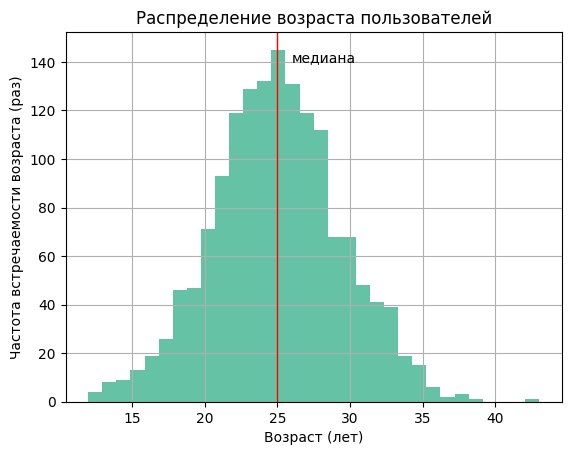

In [25]:
# строим гистограмму
users["age"].hist(bins=32, range=(12, 43))

# подписываем оси и заголовки
plt.title("Распределение возраста пользователей")
plt.xlabel("Возраст (лет)")
plt.ylabel("Частота встречаемости возраста (раз)")

# добавляем медиану
plt.axvline(users["age"].median(), color="r", linestyle="-", linewidth=1)
plt.text(26, 140, "медиана", rotation=0);

In [26]:
# выведет топ 3 самых частых возраста в датасете
users["age"].value_counts().head(3)

age
25    145
24    132
26    131
Name: count, dtype: int64

**Наблюдение:**  распределение схоже с нормальным, без выбросов. Минимальный возраст пользователей приложения — 12 лет. Скорее всего приложение ограничивает возможность регистрации детям до 12. Чаще всего встречаются пользователи 25 лет, этот же возраст получается при расчете среднего и медианы по столбцу.

### Расстояние за одну поездку

Применим к столбцу `'distance'` метод describe() и визуализируем распределение дистанции на гистрограмме.

In [27]:
rides["distance"].describe()

count   18068.000
mean     3070.660
std      1116.831
min         0.856
25%      2543.226
50%      3133.610
75%      3776.223
max      7211.008
Name: distance, dtype: float64

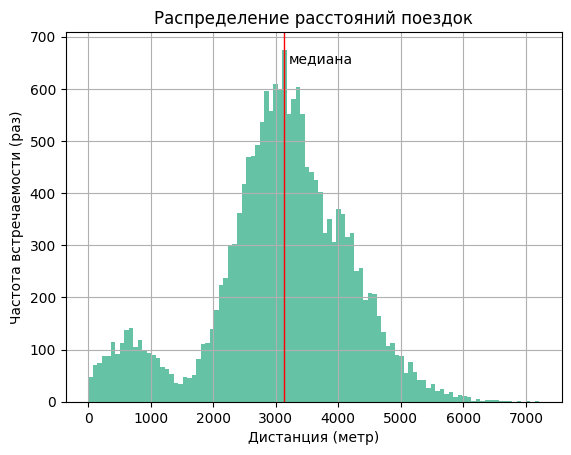

In [28]:
# строим гистограмму
rides["distance"].hist(bins=100)

# подписываем оси и заголовки
plt.title("Распределение расстояний поездок")
plt.xlabel("Дистанция (метр)")
plt.ylabel("Частота встречаемости (раз)")

# добавляем медиану
plt.axvline(rides["distance"].median(), color="r", linestyle="-", linewidth=1)
plt.text(3200, 650, "медиана", rotation=0);

**Наблюдение:** У распределения два выраженных пика — около 600 и 3100 метров. Медиана находится в районе пика 3100 и равна 3133 м.

### Продолжительность поездок

Применим к столбцу `'duration'` метод describe() и визуализируем распределение продолжительности поездок на гистрограмме.

In [29]:
rides["duration"].describe()

count   18068.000
mean       17.805
std         6.091
min         0.500
25%        13.598
50%        17.678
75%        21.725
max        40.824
Name: duration, dtype: float64

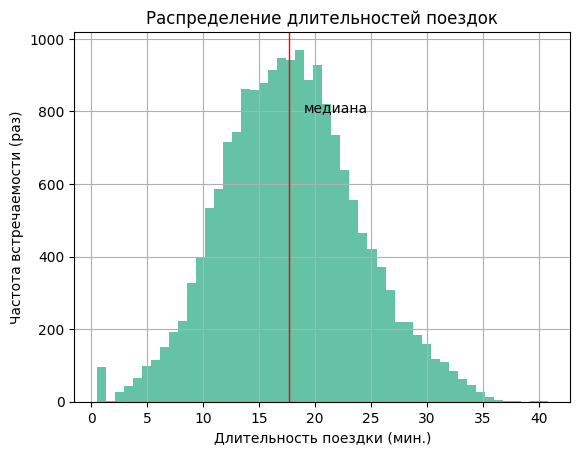

In [30]:
# строим гистограмму
rides["duration"].hist(bins=50)

# подписываем оси и заголовки
plt.title("Распределение длительностей поездок")
plt.xlabel("Длительность поездки (мин.)")
plt.ylabel("Частота встречаемости (раз)")

# добавляем медиану
plt.axvline(rides["duration"].median(), color="r", linestyle="-", linewidth=1)
plt.text(19, 800, "медиана", rotation=0);

Интересный выброс в районе 0.5 минут. Сделаем срез данных по этой длительности и изучим поближе.

In [31]:
rides.query("duration == 0.5")

,user_id,distance,duration,date,month
6531,701,4196.445,0.500,2021-08-31,8
6570,704,4830.824,0.500,2021-10-14,10
6680,712,4684.004,0.500,2021-03-04,3
6695,713,5215.643,0.500,2021-02-25,2
6768,718,5197.437,0.500,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.336,0.500,2021-01-19,1
17242,1477,6724.933,0.500,2021-01-12,1
17314,1483,4445.481,0.500,2021-03-06,3
17505,1496,5722.552,0.500,2021-02-14,2


95 строк с длительностью 30 секунд. При этом расстояние во многих строках больше километра. Похоже на сбой в системе подсчета длительности. 

Уточним какая длительность будет самой короткой, если отсечь 0.5

In [32]:
rides[rides["duration"] != 0.5].sort_values(by="duration", ascending=True).head()

,user_id,distance,duration,date,month
8906,880,11.284,2.036,2021-03-28,3
6691,712,23.963,2.053,2021-11-22,11
13308,1198,84.410,2.181,2021-06-11,6
17309,1482,111.299,2.223,2021-07-24,7
14081,1251,41.213,2.225,2021-04-15,4


Длительности начинаются от 2-х минут.
Оставим пока эти строки в таблице, так как их количество очень небольшое относительно размера таблицы.

**Наблюдение:** Распределение частот длительностей напоминает нормальное, есть небольшой подозрительный пик в районе 0,5 минут, происхождение которого хорошо бы уточнить. Медиана и среднее очень близки по значению, приходятся на вершину гистограммы и равны примерно 18 минутам.

###  Особенности пользователей с подпиской Ultra и без

Подготовим данные, чтобы изучить две эти категории. Объединим данные о пользователях, поездках и подписках в один датафрейм.
Затем на основе нового датафрейма создадим ещё два:
* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

In [33]:
# объединение датафреймов
merged_data = pd.merge(rides, users, how="left", on="user_id")
merged_data = pd.merge(merged_data, subscriptions, how="left", on="subscription_type")

# вывод первых строк таблица на экран
merged_data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919,25.600,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592,15.817,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.160,6.232,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783,18.511,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687,26.266,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Сверим количество строк в исходной и новой таблице, а также проверим новую таблицу на появление пропусков и дубликатов.

In [34]:
print("Количество строк в исходном датафрейме 'rides' = ", rides.shape[0])
print("Количество строк в новом датафрейме 'merged_data' = ", merged_data.shape[0])
print(
    "Количество дубликатов в новом датафрейме 'merged_data' = ",
    merged_data.duplicated().sum(),
)
print()
print("Количество пропусков в столбцах нового датафрейма 'merged_data':")
merged_data.isna().sum()

Количество строк в исходном датафрейме 'rides' =  18068
Количество строк в новом датафрейме 'merged_data' =  18068
Количество дубликатов в новом датафрейме 'merged_data' =  0

Количество пропусков в столбцах нового датафрейма 'merged_data':


user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Все хорошо, можно переходить созданию дополнительных датафреймов.

**Создание дополнительных датафреймов по двум категориям пользователей.**

* в переменную `subscription_free` сохраним даные о пользователях без подписки;
* в переменную `subscription_ultra` сохраним данные о пользователях с подпиской.

In [35]:
subscription_free = merged_data.query('subscription_type == "free"')
subscription_ultra = merged_data.query('subscription_type == "ultra"')

**Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий**

Для сравнения информации сначала уточним среднее и сумму столбцов по каждой категории с помощью сводной таблицы.

In [36]:
merged_data.pivot_table(
    index="subscription_type", values=["duration", "distance"], aggfunc=["sum", "mean"]
)

sum                mean         
                      distance   duration distance duration
subscription_type                                          
free              35230289.418 201178.039 3045.495   17.391
ultra             20250395.022 120522.904 3115.445   18.542

**Наблюдение:**  В среднем пользователи с подпиской Ultra совершают более длительные и длинные поездки. Но разница небольшая, всего 70 м и 1 минута. 

---

Теперь сравним распределение длительностей на гистограмме, а также построим барплот, на котором сравним суммы длительностей всех поездок за период, охваченный датафреймом.

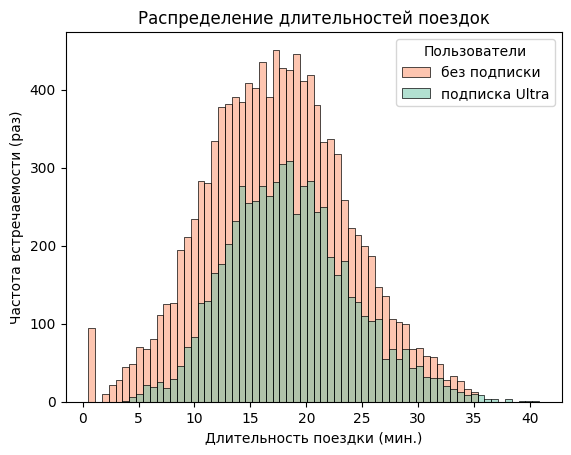

In [37]:
# задаем цвета библиотеки
sns.set_palette("Set2")

# подписываем оси
plt.xlabel("Длительность поездки (мин.)")
plt.ylabel("Частота встречаемости (раз)")

# строим гистограмму
sns.histplot(data=merged_data, x="duration", hue="subscription_type").set(
    title="Распределение длительностей поездок"
)
plt.legend(
    title="Пользователи", loc="upper right", labels=["без подписки", "подписка Ultra"]
);

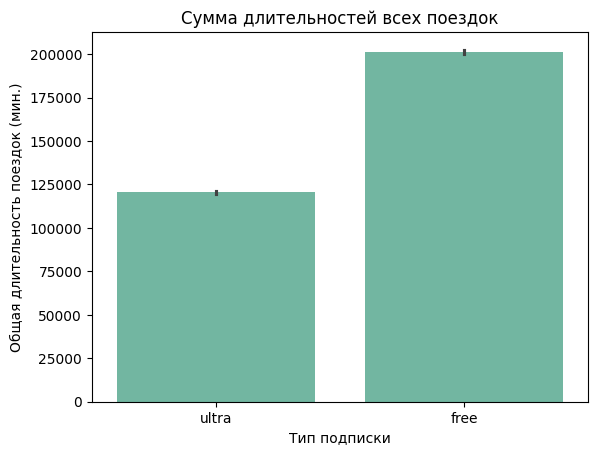

In [38]:
# строим барплот
sns.barplot(data=merged_data, y="duration", x="subscription_type", estimator=sum).set(
    title="Сумма длительностей всех поездок"
)

# подписываем оси
plt.xlabel("Тип подписки")
plt.ylabel("Общая длительность поездок (мин.)");

**Наблюдение:** Распределения достаточно похожи по расположению пика (мы знаем, что у пользователей подписки средняя длительность чуть больше). Видно, что самих поездок у пользователей подписки меньше по объему.

Это наглядно видно на барплоте выше, где показаны суммы всех длительностей. Пользователи подписки использовали сервис 120523 минуты (2008 часов), тогда как пользователи без подписки — 201178 минут (3353 часа)

Аномальное значение 0.5 минут встречается только у пользователей без подписки. Отметим это на будущее.

---

Теперь давайте построим такие же графики для информации о дистанции поездок.

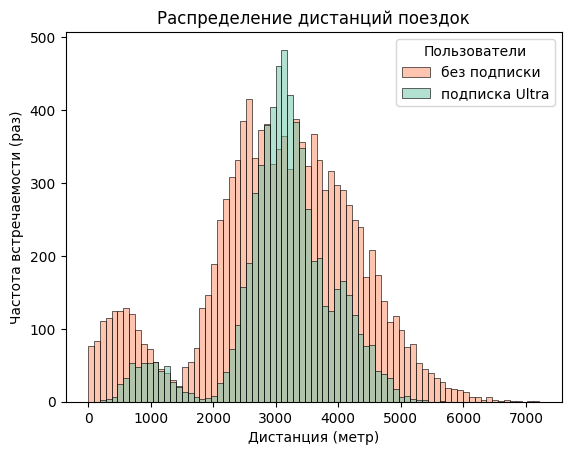

In [39]:
# подписываем оси
plt.xlabel("Дистанция (метр)")
plt.ylabel("Частота встречаемости (раз)")

# строим гистограмму
sns.histplot(data=merged_data, x="distance", hue="subscription_type").set(
    title="Распределение дистанций поездок"
)
plt.legend(
    title="Пользователи", loc="upper right", labels=["без подписки", "подписка Ultra"]
);

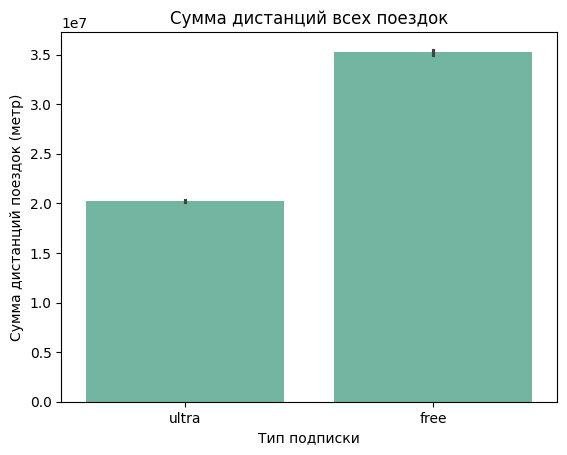

In [40]:
# строим барплот
sns.barplot(data=merged_data, y="distance", x="subscription_type", estimator=sum).set(
    title="Сумма дистанций всех поездок"
)

# подписываем оси
plt.xlabel("Тип подписки")
plt.ylabel("Сумма дистанций поездок (метр)");

**Наблюдение:** Распределение дистанций у подписчиков ultra смещено вправо, особенно сместился небольшой пик слева.
Общая дистанция у пользователей с подпиской меньше.

### Промежуточный вывод

Мы изучили и описали несколько параметров:
* **Частота встречаемости городов** — больше всего пользователей из Пятигорска, меньше всего — из Москвы
* **Соотношение пользователей с подпиской и без подписки** — пользователей без подписки — 54 %, с подпиской — 45.6 %
* **Возраст пользователей** — от 12 до 43 лет, в среднем возраст пользователей — 25 лет.
* **Расстояние, которое пользователь преодолел за одну поездку** — У распределения два выраженных пика — около 600 и 3100 метров.
* **Продолжительность поездок** — средняя продолжительность поездок — 18 минут.
* **Особенности пользователей с подпиской Ultra и без** — в среднем пользователи с подпиской Ultra совершают более длительные и длинные поездки. Но разница небольшая, всего 70 м и 1 минута. Общее количество поездок у пользователей подписки меньше.

## Подсчёт выручки

#### Создание сводной таблицы

Нас интересуют: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [41]:
# каждое значение из столбца duration округляется с помощью «потолка»:
merged_data["duration"] = np.ceil(merged_data["duration"])

In [42]:
# создаем сводную таблицу с сортировкой по столбцу 'user_id'
merged_data_pivot = merged_data.pivot_table(
    index="user_id",
    values=["duration", "distance"],
    columns=["month"],
    aggfunc=["sum", "count"],
)

# добавляем новый уровень (месяцы) к индексу
merged_data_pivot = merged_data_pivot.stack()
# удаляем лишний столбец
merged_data_pivot = merged_data_pivot.drop(
    columns=[("count", "duration")]
).reset_index()
# присваиваем названия столбцам
merged_data_pivot.columns = [
    "user_id",
    "month",
    "total_distance",
    "total_time",
    "rides_count",
]
# меняем тип данных в столбце 'rides_count'
merged_data_pivot["rides_count"] = merged_data_pivot["rides_count"].astype("int")

In [43]:
# выводим первые строки получившейся таблицы на экран
merged_data_pivot.head(10)

,user_id,month,total_distance,total_time,rides_count
0,1,1,7027.511,42.000,2
1,1,4,754.160,7.000,1
2,1,8,6723.471,46.000,2
3,1,10,5809.911,32.000,2
4,1,11,7003.499,56.000,3
5,1,12,6751.630,28.000,2
6,2,3,10187.723,63.000,3
7,2,4,6164.382,40.000,2
8,2,6,3255.338,14.000,1
9,2,7,6780.723,48.000,2


Выглядит хорошо, идем дальше.

### Расчет выручки по месяцам

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.
Сначала создадим таблицу, в которой будет информация о подписке по каждому уникальному пользователю.

In [44]:
# делаем срез изначального датафрейма 'users'
users_slice = users[["user_id", "subscription_type"]]
# добавляем информацию из датафрейма 'subscriptions'
user_subscription = pd.merge(
    users_slice, subscriptions, how="left", on="subscription_type"
)

user_subscription.head()

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,ultra,6,0,199
1,2,ultra,6,0,199
2,3,ultra,6,0,199
3,4,ultra,6,0,199
4,5,ultra,6,0,199


Теперь добавим эту информацию в сводную таблицу, которую мы создали ранее:

In [45]:
merged_data_pivot = pd.merge(
    merged_data_pivot, user_subscription, how="left", on="user_id"
)
merged_data_pivot.head()

,user_id,month,total_distance,total_time,rides_count,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511,42.000,2,ultra,6,0,199
1,1,4,754.160,7.000,1,ultra,6,0,199
2,1,8,6723.471,46.000,2,ultra,6,0,199
3,1,10,5809.911,32.000,2,ultra,6,0,199
4,1,11,7003.499,56.000,3,ultra,6,0,199


Теперь можно подсчитать помесячную выручку для каждого пользователя.

In [46]:
# считаем выручку и добавляем ее в новый столбец 'monthly_revenue'
merged_data_pivot["monthly_revenue"] = (
    (merged_data_pivot["start_ride_price"] * merged_data_pivot["rides_count"])
    + (merged_data_pivot["minute_price"] * merged_data_pivot["total_time"])
    + merged_data_pivot["subscription_fee"]
)
# удаляем ненужные столбцы
merged_data_pivot = merged_data_pivot[
    [
        "user_id",
        "month",
        "total_distance",
        "total_time",
        "rides_count",
        "monthly_revenue",
        "subscription_type",
    ]
]

# смотрим что получилось
merged_data_pivot.head()

,user_id,month,total_distance,total_time,rides_count,monthly_revenue,subscription_type
0,1,1,7027.511,42.000,2,451.000,ultra
1,1,4,754.160,7.000,1,241.000,ultra
2,1,8,6723.471,46.000,2,475.000,ultra
3,1,10,5809.911,32.000,2,391.000,ultra
4,1,11,7003.499,56.000,3,535.000,ultra


Посмотрим на распределение выручки на графике и применим к новому столбцу метод describe()

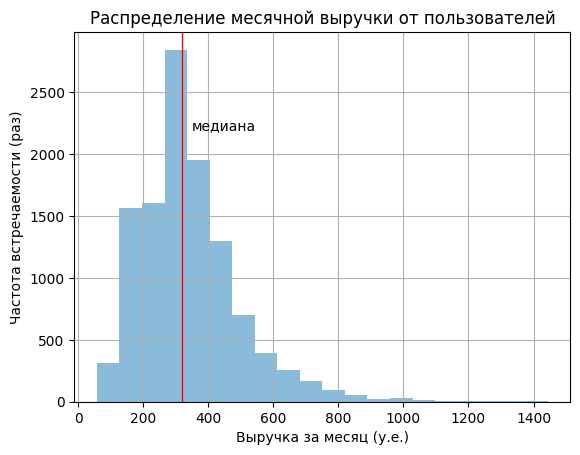

In [47]:
# присваиваем цвета
sns.set_palette("Blues_d")

# подписываем оси и заголовки графику
plt.title("Распределение месячной выручки от пользователей")
plt.xlabel("Выручка за месяц (у.е.)")
plt.ylabel("Частота встречаемости (раз)")

# строим гистограмму
merged_data_pivot["monthly_revenue"].hist(bins=20)

# добавляем медиану
plt.axvline(
    merged_data_pivot["monthly_revenue"].median(), color="r", linestyle="-", linewidth=1
)
plt.text(350, 2200, "медиана", rotation=0);

In [48]:
merged_data_pivot["monthly_revenue"].describe()

count   11331.000
mean      342.304
std       153.875
min        58.000
25%       234.000
50%       319.000
75%       415.000
max      1444.000
Name: monthly_revenue, dtype: float64

Посмотрим на взаимосвязь выручки и общей дистанции.

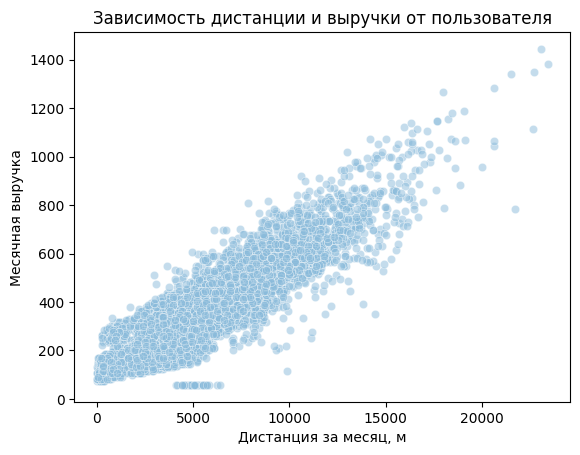

In [49]:
# строим диаграмму рассеяния
sns.scatterplot(
    data=merged_data_pivot, x="total_distance", y="monthly_revenue", alpha=0.5
)

# прописываем оси и названия
plt.title("Зависимость дистанции и выручки от пользователя")
plt.xlabel("Дистанция за месяц, м")
plt.ylabel("Месячная выручка");

In [50]:
print(
    "Коэффициент Пирсона общей дистанции к выручке равен",
    round(
        merged_data_pivot["total_distance"].corr(merged_data_pivot["monthly_revenue"]),
        2,
    ),
)

Коэффициент Пирсона общей дистанции к выручке равен 0.87


### Промежуточный вывод

Мы составили таблицу с данными о доходах от каждого клиента за каждый месяц и представили их в виде графика.

* Оказалось, что средний доход с одного пользователя составляет 320 условных единиц в месяц. При этом наблюдается сильная положительная корреляция между месячной выручкой и общей дистанцией, хотя она и не учитывается при расчёте первого показателя.

## Проверка гипотез

### Гипотеза №1

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

**Формулируем гипотезу:**

Будем сравнивать две выборки:

1 - длительностей категории `'подписка ultra'`\
2 - длительностей категории `'без подписки'`

Нулевая гипотеза — среднее значение всех длительностей категории `'подписка ultra'` `=` среднему значению всех длительностей категории `'без подписки'`

Альтернативная гипотеза — среднее значение всех длительностей категории `'подписка ultra'` `>` среднего значения всех длительностей категории `'без подписки'`

Таким образом альтернативная гипотеза — правосторонняя.

In [51]:
# задаём уровень значимости
alpha = 0.05

# длительности первой группы пользователей (с подпиской ultra)
ultra_durations = subscription_ultra["duration"]

# длительности второй группы пользователей (без подписки)
free_durations = subscription_free["duration"]

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(
    ultra_durations, free_durations, alternative="greater", equal_var=False
)

print(f"p-value: {results.pvalue}")

# проверяем p-value
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


**Вывод** 

Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу.
Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки

### Гипотеза №2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.
Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Формулируем гипотезу:**

Будем сравнивать одну выборку и `истинное среднее`:

1 - выборка — расстояния, которые проехали пользователи `'подписки ultra'`\
2 - `истинное среднее` — 3130 м.

Нулевая гипотеза — среднее значение всех расстояний категории `'подписка ultra'` `=` `истинному среднему` — 3130 м.

Альтернативная гипотеза — среднее значение всех длительностей категории `'подписка ultra'` `>` среднего значения всех длительностей категории `'без подписки'`

Таким образом альтернативная гипотеза — правосторонняя.

In [52]:
ultra_distances = subscription_ultra[
    "distance"
]  # создаем отдельную перементами с дистанциями всех подписчиков

optiman_distance = 3130  # задаем оптимальную дистанцию

alpha = 0.05  # уровень статистической значимости

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_1samp(ultra_distances, optiman_distance, alternative="greater")

print("p-значение:", results.pvalue)

# проверяем p-value
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

p-значение: 0.9195368847849785
Не отвергаем нулевую гипотезу


**Вывод** 

Полученное значение p-value значительно больше заданного уровня значимости, есть основания предположить, что среднее значение всех расстояний категории 'подписка ultra' около 3130 м или меньше.

### Гипотеза №3

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.


**Формулируем гипотезу:**

Будем сравнивать две выборки:

1 - помесячную выручку категории пользователей `'подписка ultra'`\
2 - помесячную выручку категории пользователей `'без подписки'`

Нулевая гипотеза — среднее значение помесячную выручку категории пользователей 'подписка ultra' `=` среднему значению помесячной выручки категории пользователей `'без подписки'`

Альтернативная гипотеза — среднее значение помесячную выручку категории пользователей 'подписка ultra' `>` среднему значению помесячной выручки категории пользователей `'без подписки'`

Таким образом альтернативная гипотеза — правосторонняя.

In [53]:
# задаём уровень значимости
alpha = 0.05

# выручки первой группы пользователей (с подпиской ultra)
ultra_income = merged_data_pivot.query('subscription_type == "ultra"')[
    "monthly_revenue"
]

# выручки второй группы пользователей (без подписки)
free_income = merged_data_pivot.query('subscription_type == "free"')["monthly_revenue"]

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(
    ultra_income, free_income, alternative="greater", equal_var=False
)

print(f"p-value: {results.pvalue}")

# проверяем p-value
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нет оснований отвергнуть нулевую гипотезу")

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Вывод** 

Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу.
Есть основания говорить, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Промежуточный вывод

В ходе исследования мы проверили несколько гипотез и пришли к следующим выводам:
* Пользователи с подпиской, вероятно, тратят больше времени на поездки.
* Можно предположить, что среднее расстояние поездок пользователей с подпиской ultra составляет 3130 метров или более.
* Месячная выручка от пользователей с подписками выше, чем от пользователей без подписки.

## Дополнительные задачи

#### Дополнительная задача №1

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают  10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%.

**Наша задача** — подобрать параметры распределения, описывающего эту ситуацию, построить график распределения и сформулируйте ответ на вопрос о количестве промокодов.

(0.0, 200.0)

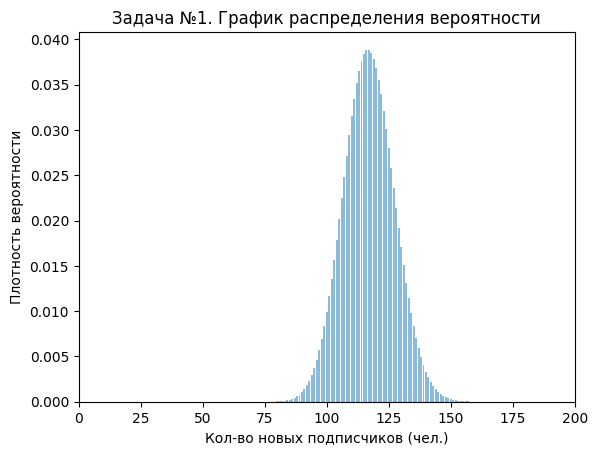

In [54]:
# подписку продлевают 10% пользователей
p = 0.1

# подобрала это значение методом подбора
n = 1170  # количество попыток

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)

plt.bar(range(0, n + 1), distr)

plt.title("Задача №1. График распределения вероятности")
plt.xlabel("Кол-во новых подписчиков (чел.)")
plt.ylabel("Плотность вероятности")

# обрежем длинный хвост гистограммы слева
plt.xlim(0, 200)

Let's check using the `cdf()` method

In [55]:
# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста слева
result = distr.cdf(100)
print(round(result * 100, 2), "%")

4.88 %


**Ответ** \
При количестве разосланных промокодов 1170 вероятность не выполнить план
(получить минимум 100 новых подписчиков) будет примерно 5%.

#### Дополнительная задача №2

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений.

**Наша задача** — с помощью аппроксимации построить примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [56]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma)

# считаем вероятность хвоста слева
result = distr.cdf(399500)
print(round(result * 100, 2), "%")

15.37 %


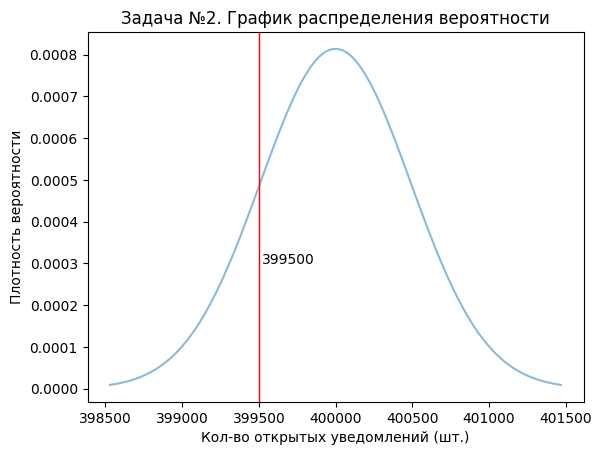

In [57]:
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma))

plt.title("Задача №2. График распределения вероятности")
plt.xlabel("Кол-во открытых уведомлений (шт.)")
plt.ylabel("Плотность вероятности")

plt.axvline(399500, color="r", linestyle="-", linewidth=1)
plt.text(399520, 0.0003, "399500", rotation=0);

**Ответ**\
Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей при рассылке 1 млн уведомлений составляет 15.37 %

## Итоги исследования

**`В рамках предобработки данных:`**

* Проверили данные на наличие пропусков, а также явных и неявных дубликатов (удалили явные и обнаружили отсутствие скрытых)
* В датасете `rides` — добавили новый столбец `month`, а также исправили тип столбца `date` на datetime64

**`В рамках исследовательского анализа:`**

Изучили и описали несколько параметров:
* **Частота встречаемости городов** — больше всего пользователей из Пятигорска, меньше всего — из Москвы
* **Соотношение пользователей с подпиской и без подписки** — пользователей без подписки — 54 %, с подпиской — 45.6 %
* **Возраст пользователей** — от 12 до 43 лет, в среднем возраст пользователей — 25 лет.
* **Расстояние, которое пользователь преодолел за одну поездку** — У распределения два выраженных пика — около 600 и 3100 метров.
* **Продолжительность поездок** — средняя продолжительность поездок — 18 минут.
* **Особенности пользователей с подпиской Ultra и без** — в среднем пользователи с подпиской Ultra совершают более длительные и длинные поездки. Но разница небольшая, всего 70 м и 1 минута. Общее количество поездок у пользователей подписки меньше.


**`В ходе исследования мы проверили несколько гипотез и пришли к следующим выводам:`**

* Пользователи с подпиской, вероятно, тратят больше времени на поездки.
* Можно предположить, что среднее расстояние поездок пользователей с подпиской ultra составляет 3130 метров или более.
* Месячная выручка от пользователей с подписками выше, чем от пользователей без подписки.

**`Рекомендации:`**

* Исследование показало, что пользователи с подпиской приносят компании больше выручки. Поэтому стоит разработать стратегии для увеличения доли подписчиков среди пользователей и поиска новых клиентов.
* Стоит обратить внимание на привлечение новых пользователей старше 33 лет.
* Нужно уточнить пропорции количества пользователей по городам и сделать стратифицированную выборку.
* Следует изучить возникновение второго пика в распределении дистанций поездок. Возможно, это связано с типом поездки (прогулка или поездка с/на работу) или другими факторами.
* Необходимо исследовать зависимость количества поездок от месяца с сортировкой по городам. Если зимой в городе нельзя кататься, можно предложить сезонную подписку только на весну, лето или осень.
* Чтобы лучше понять бизнес-процессы, нужно выяснить, почему у пользователей без подписки возникают поездки длительностью полминуты. Это ошибка или акция?